##Інсталювання необхідних бібліотек та бідключення google drive

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pylab
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Завантажуємо дані та робимо передобробку

In [53]:
df = pd.read_csv("/content/drive/MyDrive/data for training/all_labour_market_ua_2024-05-23.csv")

In [54]:
# знайдемо загальну кількість записів
df.shape

(124982, 17)

In [55]:
len(df["Місто"].unique())
# отримана кількість міст трохи більша аніж кількість адміністративних центрів
# в Україні, тож відберемо для подальшого аналізу тільки найбільші адмін. центри

1633

In [56]:
# виділимо ці самі найбільші міста України
main_city = df.groupby("Місто").size().sort_values(ascending=False).head(22)
cities = main_city.index.drop("Вся Україна")
df = df[df["Місто"].isin(cities)]

In [57]:
df.head()

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Додаткова інформація,Посилання
0,"Водій, кур'єр на власному авто",Perfect Balance,Київ,Сфера обслуговування,0,13520.0,27000.0,1,NaN,1,0,0,0,0,0,NaN,https://www.work.ua/jobs/5151657/
1,"Мастер манікюру, педикюру",Арiкs,Київ,Сфера обслуговування,0,16000.0,30000.0,2,Середня спеціальна освіта,1,0,0,0,0,0,салон красоты,https://www.work.ua/jobs/1705625/
2,"Продавець-консультант, помічник сомельє",OKwine,Київ,Сфера обслуговування,0,NaN,NaN,0,NaN,1,0,0,0,0,0,мережа виномаркетів,https://www.work.ua/jobs/5230134/
3,Пекар-кондитер,Намелака,Київ,Сфера обслуговування,0,25000.0,28000.0,1,NaN,1,0,0,0,0,0,NaN,https://www.work.ua/jobs/5166912/
4,Кондитер відділу збірки тортів,Намелака,Київ,Сфера обслуговування,0,28000.0,32000.0,1,NaN,1,0,0,0,0,0,NaN,https://www.work.ua/jobs/5166702/


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114173 entries, 0 to 124981
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Назва роботи                     114173 non-null  object 
 1   Назва компанії                   114173 non-null  object 
 2   Місто                            114173 non-null  object 
 3   Категорія вакансії               114173 non-null  object 
 4   Стажування / Навчання на роботі  114173 non-null  int64  
 5   Мінімальна ЗП                    80958 non-null   float64
 6   Максимальна ЗП                   80958 non-null   float64
 7   Необхідний досвід                114173 non-null  int64  
 8   Необхідна освіта                 34898 non-null   object 
 9   Повна зайнятість                 114173 non-null  int64  
 10  Неповна зайнятість               114173 non-null  int64  
 11  Студент                          114173 non-null  int64  
 12  Інвалід

In [59]:
# також зробимо вимушені передобробки даних
df["Необхідний досвід"] = df["Необхідний досвід"].replace(6, 0.5)
df["Необхідний досвід"] = df["Необхідний досвід"].replace(3, 0.25)
df["Необхідна освіта"] = df["Необхідна освіта"].replace(np.NaN, "Не вказано")
# також видалимо всі вакансії пов'язані з військовими, щоб максимально побачити
# реальну ситуацію на цивільному ринку праці
df = df[~df["Назва компанії"].str
        .contains(r"ТрО|батальон|ЗСУ|батальйон|ОМБр|ОДШБр|Військова частина|РТЦК|української армії|ДШВ|ОБМП|ОБрМП|ОАеМБр|ОТЦК|ОЄБр", na=False)]
df = df[~(df["Назва компанії"] == "Компанія прихована")]

##Проведемо певне дослідження по типу EDA

###Дослідження даних в яких не вказана заробітна плата

In [60]:
# знайдемо відсоток пропущених даних заробітної плати, вони ідентичні у двох варіантах
print(df["Мінімальна ЗП"].isnull().sum() / df["Мінімальна ЗП"].count())

0.41657506033382613


Як бачимо ситуація доволі неприємна, бо ми маємо близько 42% пропущених даних стосовно заробітної плати і було б правильно видалити саме ці стовпчики (Мінімальна ЗП та Максимальна ЗП), проте загалом нас саме і цікавить інформація стосовно заробітних плат також ми маємо доволі велику виборку, тож для подальшого дослідження ми саме видалимо пусті значення в стовпчиках Мінімальна ЗП та Максимальна ЗП (через особливість збирача даних пусті значення, якщо вони є, знаходяться в однакових містах).

In [61]:
data = df[df["Мінімальна ЗП"].isna()]
data.shape

(32969, 17)

[Text(0, 0.5, 'Місто'), Text(0.5, 0, 'Кількість вакансій на Work.ua')]

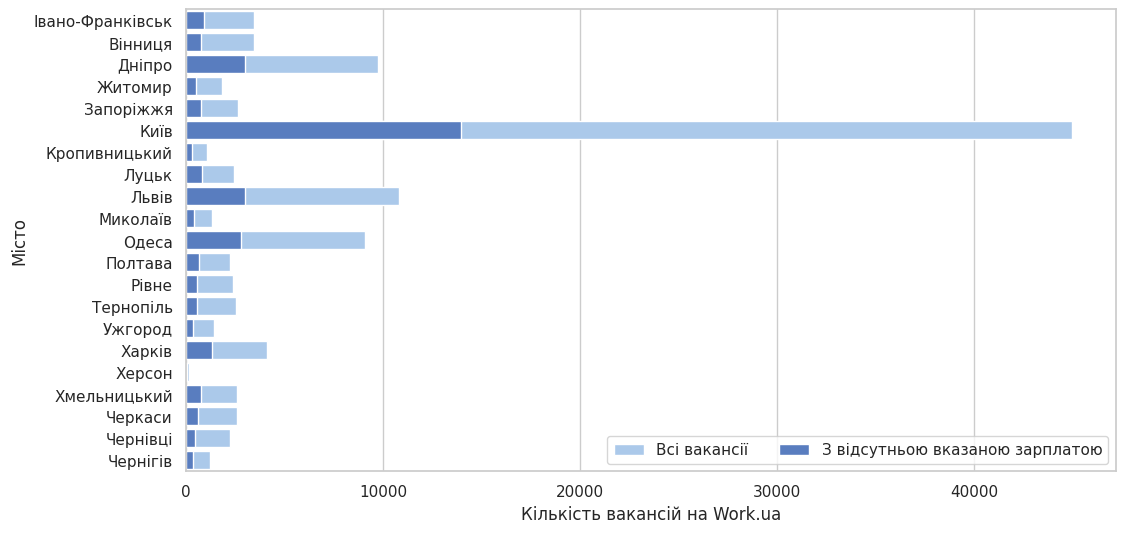

In [62]:
# зобразимо відношення кількісті вакансій з відсутніми даними по зарплаті до загальної кількості вакансій по містам України
grouped_data1 = df.groupby("Місто").size().reset_index(name="Кількість")
nan_category1 = data.groupby("Місто").size().reset_index(name="Кількість")

f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="Кількість", y="Місто", data=grouped_data1,
            label="Всі вакансії", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Кількість", y="Місто", data=nan_category1,
            label="З відсутньою вказаною зарплатою", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Місто", xlabel="Кількість вакансій на Work.ua")
# sns.despine(left=True, bottom=True)

З графіку зрозуміло, що найбільше таких вакансій (з відсутньою вказаною заробітною платою) саме у великих містах України, що вцілому й не дивно. Цікаво спостерігати, що в топі по кількості вакансій знаходиться Харків, в якому наразі доволі важка ситуація.

[Text(0, 0.5, 'Категорії вакансій'),
 Text(0.5, 0, 'Кількість вакансій на Work.ua')]

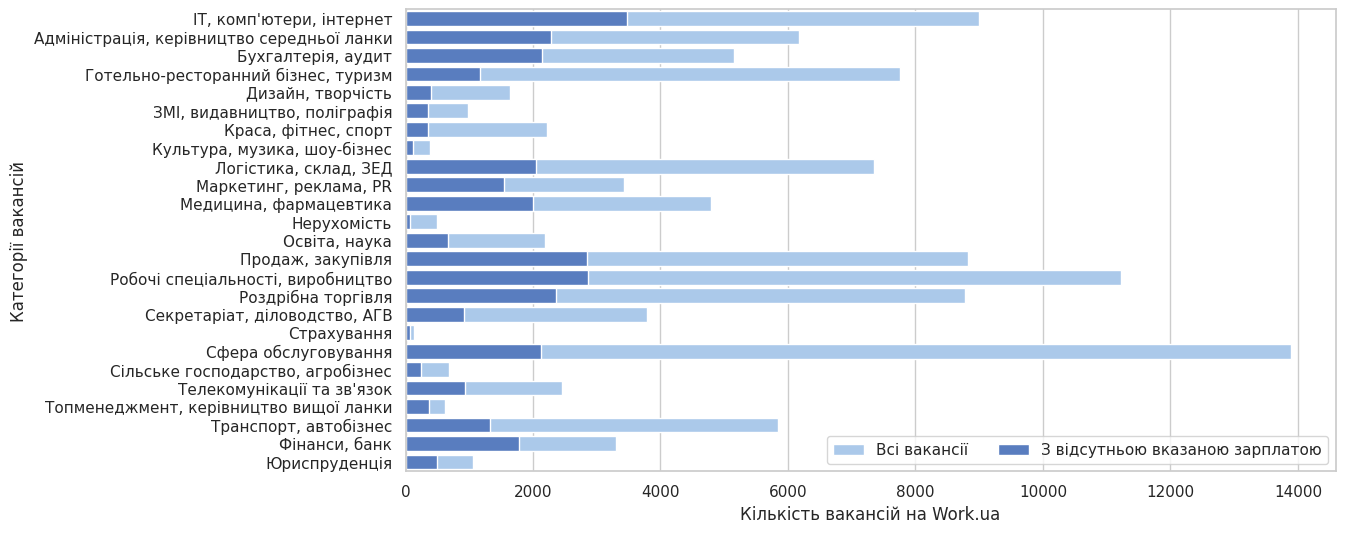

In [63]:
# зобразимо відношення кількісті вакансій з відсутніми даними по зарплаті до загальної кількості вакансій
grouped_data = df.groupby("Категорія вакансії").size().reset_index(name="Кількість")
nan_category = data.groupby("Категорія вакансії").size().reset_index(name="Кількість")

f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="Кількість", y="Категорія вакансії", data=grouped_data,
            label="Всі вакансії", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Кількість", y="Категорія вакансії", data=nan_category,
            label="З відсутньою вказаною зарплатою", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Категорії вакансій", xlabel="Кількість вакансій на Work.ua")
# sns.despine(left=True, bottom=True)

In [64]:
# для більшої наочності зобразимо топ 5 категорій по найбільшому співвідношенню
merged_data = grouped_data.merge(nan_category, how="inner", on="Категорія вакансії")
merged_data.rename(columns={"Кількість_x": "Загальна кількість вакансій", "Кількість_y": "Кількість з відсутньою зарплатою"}, inplace=True)
merged_data["Співвідношення, %"] = merged_data["Кількість з відсутньою зарплатою"] / merged_data["Загальна кількість вакансій"]
merged_data.sort_values(by="Співвідношення, %", ascending=False).head(5)

,Категорія вакансії,Загальна кількість вакансій,Кількість з відсутньою зарплатою,"Співвідношення, %"
21,"Топменеджмент, керівництво вищої ланки",627,372,0.593301
17,Страхування,127,69,0.543307
23,"Фінанси, банк",3304,1774,0.536925
24,Юриспруденція,1058,492,0.465028
9,"Маркетинг, реклама, PR",3423,1547,0.451943


In [65]:
merged_data.sort_values(by="Співвідношення, %", ascending=False).tail(5)

,Категорія вакансії,Загальна кількість вакансій,Кількість з відсутньою зарплатою,"Співвідношення, %"
22,"Транспорт, автобізнес",5836,1322,0.226525
6,"Краса, фітнес, спорт",2212,346,0.156420
11,Нерухомість,487,75,0.154004
18,Сфера обслуговування,13895,2129,0.153221
3,"Готельно-ресторанний бізнес, туризм",7754,1176,0.151664


Бачимо що в топі знаходяться такі категорії: топменеджмент, керівництво вищої ланки; страхування; фінанси, банк; юриспруденція; маркетинг, реклама, PR. Скоріше така тенденція пов'язана з тим що компанії спрешу роблять об'яву про розміщення вакансії, а вже впродовж співбесід(и), виходячи з навичок кандидата, вони або йому відмовляють або домовляються про його зарплату. Для дослідження, яке було спрямоване на аналіз ринку праці в Україні, відсутність більше третини даних є суттєвим, проте все ж дозволяє оцінити доступний ринок праці. Найменше співвідношення вакансій з відсутньою зарплатою спостерігається в категоріях: транспорт, автобізнес; краса, фітнес, спорт; нерухомість; сфера обслуговування; готельно-ресторанний бізнес, туризм. В цілому тут все зрозуміло, адже дані категорії шукають людину, яка буде виконувати поставлені завдання здебільшого без попередного формування зарплати виходячи з навичко кандидата. При цьому варто відмітити, що мале співвідношення має категорія нерухомості, що доволі цікаво спостерігати, можливо це пов'язано з спецфікою даної категорії: торгівлі та спілкуванням з потенційними клієнтами, що не вимагає критичних навичок на перший погляд.

In [66]:
df = df[df["Мінімальна ЗП"] >= 1700]
df = df.dropna(subset="Мінімальна ЗП")

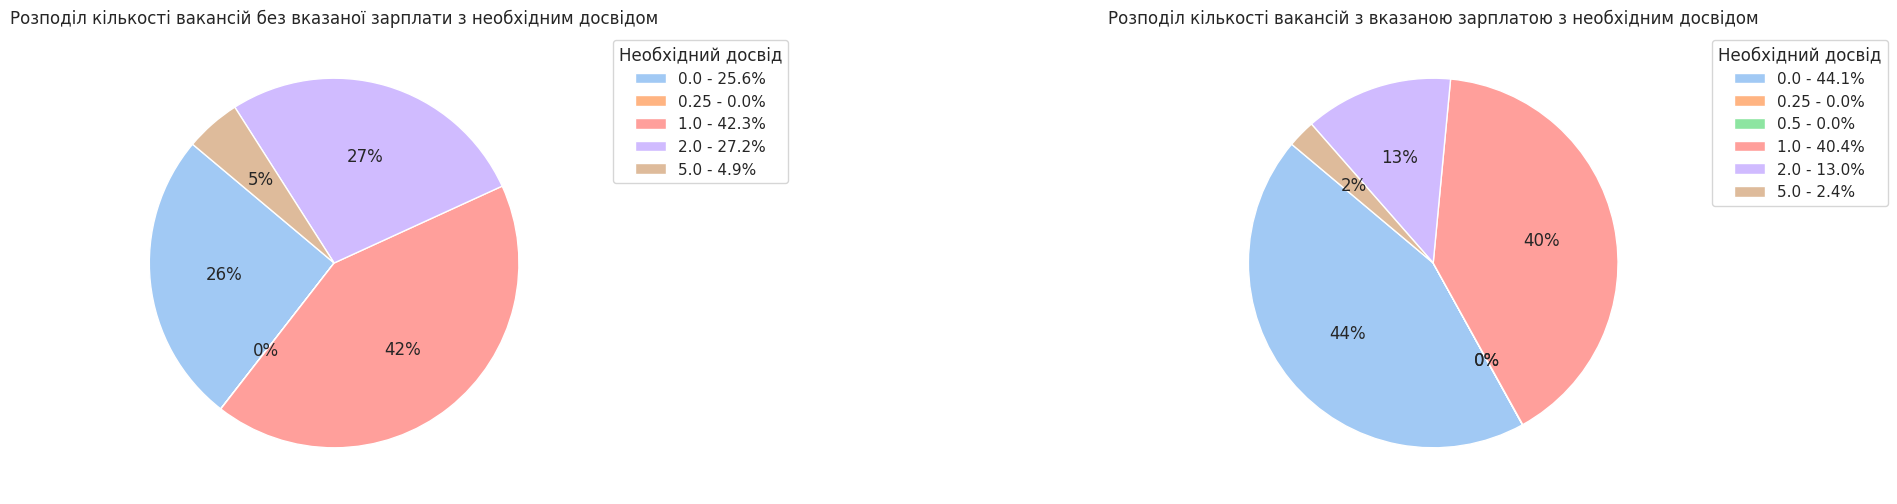

In [67]:
grouped_data3 = data.groupby("Необхідний досвід").size()
percentages3 = grouped_data3 / grouped_data3.sum() * 100

grouped_data4 = df.groupby("Необхідний досвід").size()
percentages4 = grouped_data4 / grouped_data4.sum() * 100

all_experience_levels = sorted(set(grouped_data3.index).union(set(grouped_data4.index)))
colors = sns.color_palette("pastel", len(all_experience_levels))
color_mapping = {exp: color for exp, color in zip(all_experience_levels, colors)}

# Функція для отримання кольору відповідно до групи
def get_colors(grouped_data):
    return [color_mapping[exp] for exp in grouped_data.index]

f, ax = plt.subplots(1, 2, figsize=(26, 6))

# перший pie chart
wedges3, texts3, autotexts3 = ax[0].pie(grouped_data3, colors=get_colors(grouped_data3), autopct='%.0f%%', startangle=140)
legend_labels3 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data3.index, percentages3)]
ax[0].legend(wedges3, legend_labels3, title="Необхідний досвід", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[0].set_title("Розподіл кількості вакансій без вказаної зарплати з необхідним досвідом")

# другий pie chart
wedges4, texts4, autotexts4 = ax[1].pie(grouped_data4, colors=get_colors(grouped_data4), autopct='%.0f%%', startangle=140)
legend_labels4 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data4.index, percentages4)]
ax[1].legend(wedges4, legend_labels4, title="Необхідний досвід", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[1].set_title("Розподіл кількості вакансій з вказаною зарплатою з необхідним досвідом")

plt.show()

Як бачимо наша гіпотеза має певне підтвердження, адже при невказаній зарплаті, більше вимагається досвіду за яким уже є сформовані навички кандидата, де вже під час співбесід(и) буде сформована його заробітна плата.

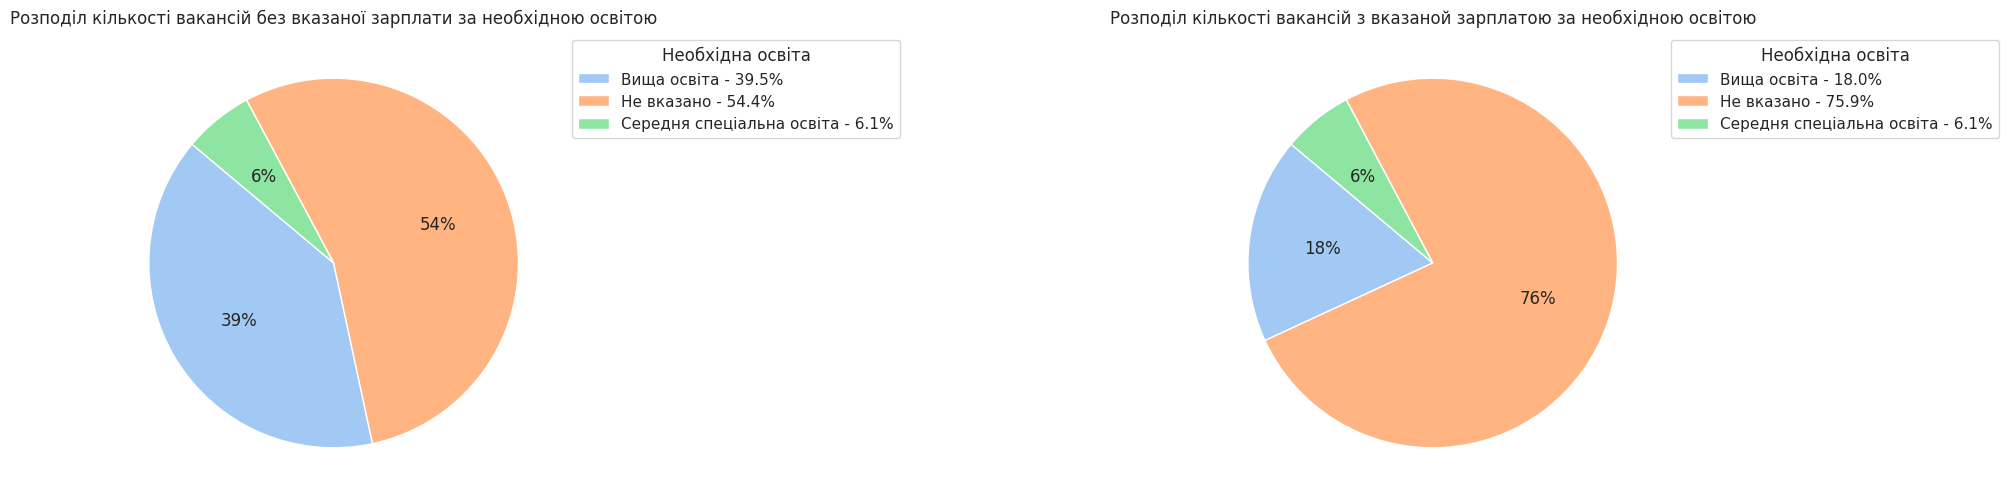

In [68]:
grouped_data3 = data.groupby("Необхідна освіта").size()
percentages3 = grouped_data3 / grouped_data3.sum() * 100

grouped_data4 = df.groupby("Необхідна освіта").size()
percentages4 = grouped_data4 / grouped_data4.sum() * 100

f, ax = plt.subplots(1, 2, figsize=(26, 6))
colors = sns.color_palette("pastel")[0:6]

# перший pie chart
wedges3, texts3, autotexts3 = ax[0].pie(grouped_data3, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels3 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data3.index, percentages3)]
ax[0].legend(wedges3, legend_labels3, title="Необхідна освіта", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[0].set_title("Розподіл кількості вакансій без вказаної зарплати за необхідною освітою")

# другий pie chart
wedges4, texts4, autotexts4 = ax[1].pie(grouped_data4, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels4 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data4.index, percentages4)]
ax[1].legend(wedges4, legend_labels4, title="Необхідна освіта", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[1].set_title("Розподіл кількості вакансій з вказаной зарплатою за необхідною освітою")

plt.show()

Тут теж ситуація доволі показова, ми бачимо наскільки, при невказаній зарплаті у вакансіях, збільшилася частка з вимогою вищої освіти, що теж підкріплює попередню нашу гіпотезу про спеціальні навички, за якими на етапах співбесід(и) формується заробітна плата.

###Дослідження даних в яких вказана заробітна плата

Попри ньюанси, які виникли при відсіюванні даних зарплати зі значенням Nan, все ж спробуємо виконати першу поставлену ціль: дослідження ринку праці України та аналіз зарплат.

In [69]:
# цікаво буде глянути на мінімальну та максимальну заплати
print("Мінімальна зарплата по вакансіях:", df["Мінімальна ЗП"].min())
print("Максимальна зарплата по вакансіях:", df["Максимальна ЗП"].max())

Мінімальна зарплата по вакансіях: 1700.0
Максимальна зарплата по вакансіях: 491162.0


In [70]:
# подивимося вакансії з мінімальною заробітною платою за місяць
df[df["Мінімальна ЗП"] == df["Мінімальна ЗП"].min()]

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Додаткова інформація,Посилання
26887,Адміністратор-оператор у клініку,MedLas,Київ,"Медицина, фармацевтика",0,1700.0,1700.0,1.0,Вища освіта,1,0,0,0,0,0,NaN,https://www.work.ua/jobs/5347430/
119706,Мерчендайзер,Сінерджи Форс,Хмельницький,"Продаж, закупівля",0,1700.0,1700.0,0.0,Не вказано,1,0,0,0,0,0,ТОВ,https://www.work.ua/jobs/5607786/
119980,Мерчендайзер,Сінерджи Форс,Хмельницький,Роздрібна торгівля,0,1700.0,1700.0,0.0,Не вказано,1,0,0,0,0,0,ТОВ,https://www.work.ua/jobs/5607786/
121447,Мерчендайзер,Сінерджи Форс,Хмельницький,"Маркетинг, реклама, PR",0,1700.0,1700.0,0.0,Не вказано,1,0,0,0,0,0,ТОВ,https://www.work.ua/jobs/5607786/


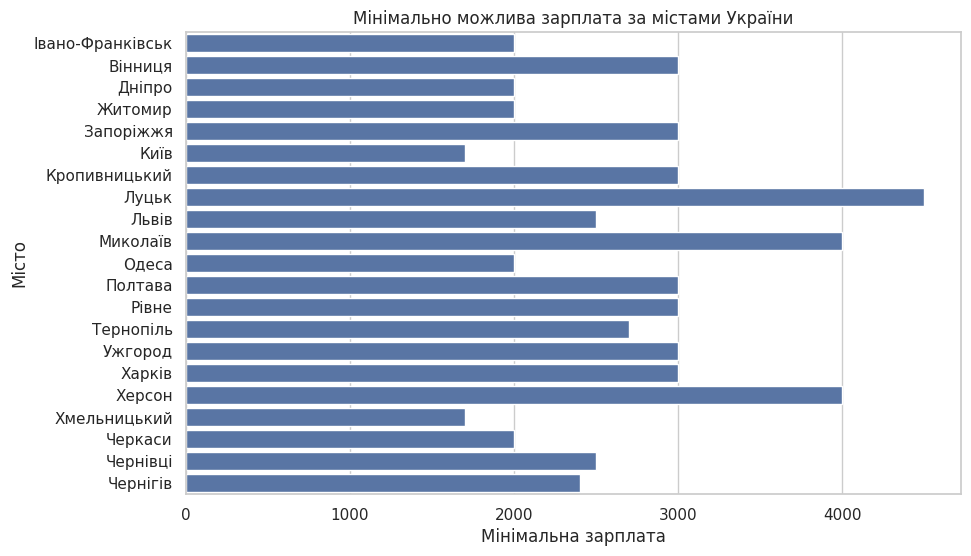

In [71]:
# потім глянемо на мінімальні зарплати по містам України
grouped_data_5 = df.groupby("Місто")["Мінімальна ЗП"].min().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_5, y="Місто", x="Мінімальна ЗП")
plt.title("Мінімально можлива зарплата за містами України")
plt.ylabel("Місто")
plt.xlabel("Мінімальна зарплата")

plt.show()

In [72]:
# також переглянемо вакансії з найбільшою зарплатою
df[df["Максимальна ЗП"] == df["Максимальна ЗП"].max()]

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Додаткова інформація,Посилання
22294,Monitoring Coordinator,Global Emergency Group,Київ,"Адмiнiстрацiя, керівництво середньої ланки",0,491162.0,491162.0,5.0,Не вказано,1,0,0,0,0,0,NaN,https://www.work.ua/jobs/5646812/
31867,Monitoring Coordinator,Global Emergency Group,Київ,"Маркетинг, реклама, PR",0,491162.0,491162.0,5.0,Не вказано,1,0,0,0,0,0,NaN,https://www.work.ua/jobs/5646812/


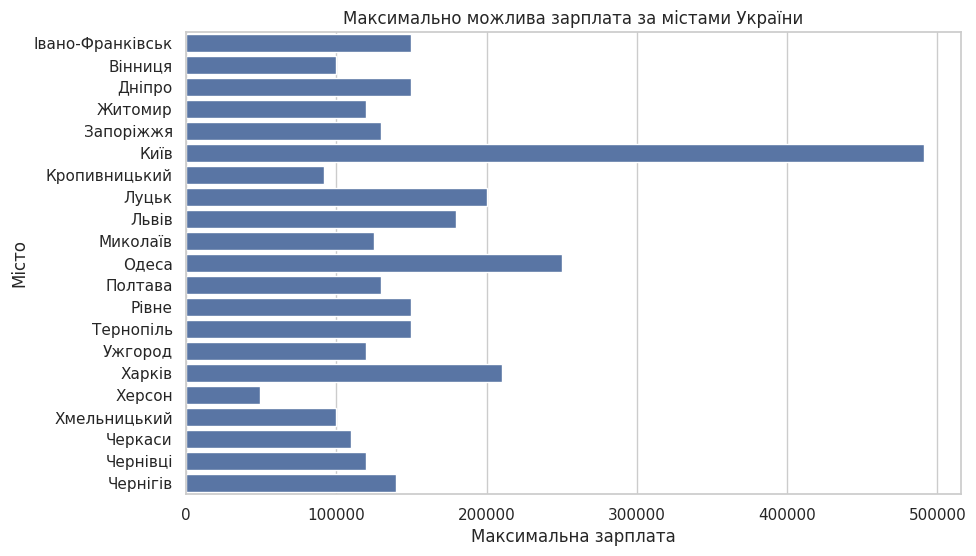

In [73]:
# переглянемо максимально можливі зарплати по містам України
grouped_data_6 = df.groupby("Місто")["Максимальна ЗП"].max().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_6, y="Місто", x="Максимальна ЗП")
plt.title("Максимально можлива зарплата за містами України")
plt.ylabel("Місто")
plt.xlabel("Максимальна зарплата")

plt.show()

In [74]:
# близько 12,44% вакансій пропонують неповну/часткову зайнятість
df["Неповна зайнятість"].sum() / df.shape[0]

0.1245970036032619

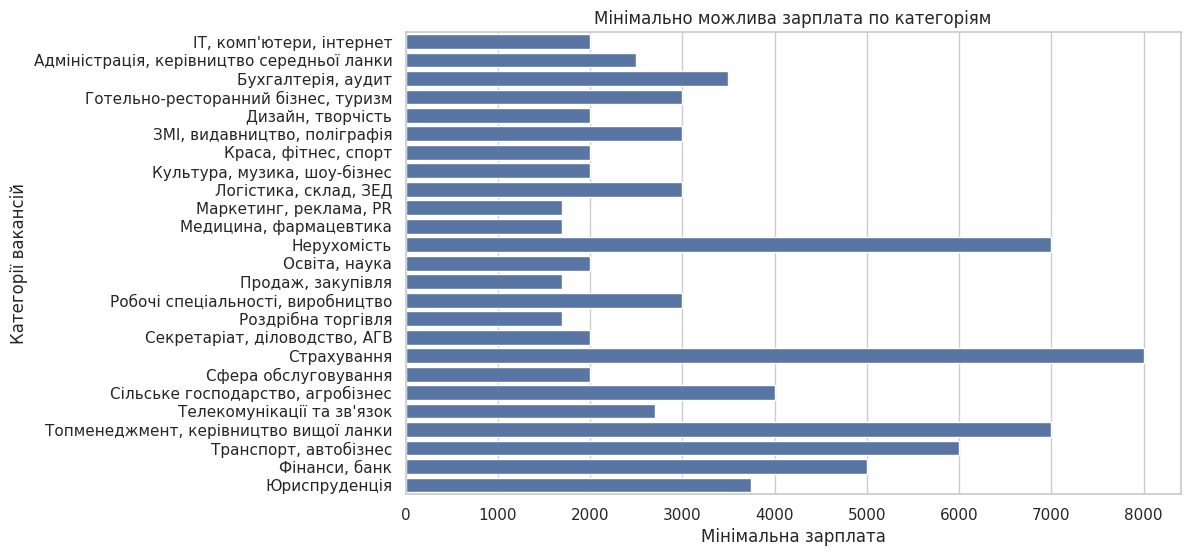

In [75]:
# мінімально можлива зарплата по категоріям, які доступні на work.ua
grouped_data_7 = df.groupby("Категорія вакансії")["Мінімальна ЗП"].min().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_7, y="Категорія вакансії", x="Мінімальна ЗП")
plt.title("Мінімально можлива зарплата по категоріям")
plt.ylabel("Категорії вакансій")
plt.xlabel("Мінімальна зарплата")

plt.show()

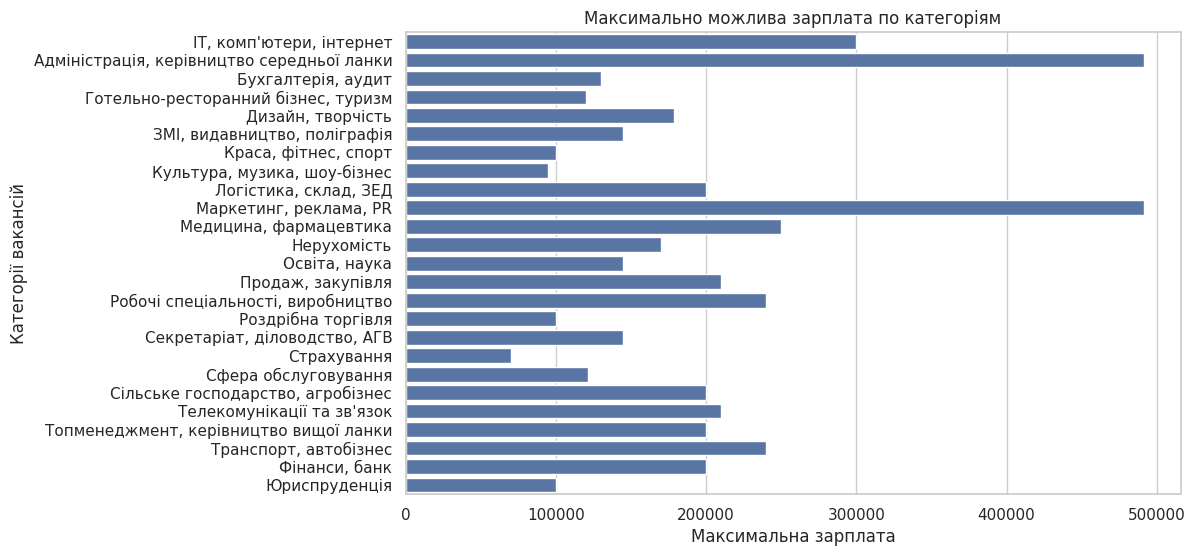

In [76]:
# максимально можлива зарплата по категоріям, які доступні на work.ua
grouped_data_8 = df.groupby("Категорія вакансії")["Максимальна ЗП"].max().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_8, y="Категорія вакансії", x="Максимальна ЗП")
plt.title("Максимально можлива зарплата по категоріям")
plt.ylabel("Категорії вакансій")
plt.xlabel("Максимальна зарплата")

plt.show()

In [77]:
# також переглянемо найбільших роботодавців на ринку (топ-15)
# та їх частку від загального ринку праці України
temp_t = df.groupby("Назва компанії").size().sort_values(ascending=False).head(15)
comp_df = pd.DataFrame(temp_t).reset_index()
comp_df.columns = ["Назва компанії", "Кількість вакансій компанії"]
comp_df["Частка від загальної кількості вакансій"] = comp_df["Кількість вакансій компанії"] / df.shape[0]
comp_df.head(15)

,Назва компанії,Кількість вакансій компанії,Частка від загальної кількості вакансій
0,Novus,759,0.009596
1,Нова пошта,608,0.007687
2,Фора,595,0.007523
3,RetailGroup,502,0.006347
4,Сільпо,497,0.006284
5,WOG,396,0.005007
6,ПриватБанк,377,0.004766
7,Аврора,345,0.004362
8,Аптека АНЦ,290,0.003666
9,OKKO,213,0.002693


In [78]:
# далі порахуємо середню зарплату: для цього додамо стовпчик, де знайдемо
# середню заробітну плату між мінімально та максимально можливими зарплатами
# у вакансіях

df["Середня зарплата"] = (df["Мінімальна ЗП"] + df["Максимальна ЗП"]) / 2

In [79]:
# Виключно з моєї цікавості хочу переглянути скільки в середньому отримують вчителя англійської мови
pattern = r"(вчитель|викладач|репетитор).*англійськ|англійськ.*(вчитель|викладач|репетитор)"
eng_data = df[df["Назва роботи"].str.contains(pattern, case=False, na=False)]
print("Всього було знайдено:", eng_data.shape[0], "з викладання англійської мови")
print("Середня зарплата з викладання англійської:", eng_data["Середня зарплата"].mean().round(2))
print("Максимально можлива зарплата з викладання англійської:", eng_data["Максимальна ЗП"].max().round(2))
print("Мінімально можлива зарплата з викладання англійської:", eng_data["Мінімальна ЗП"].min().round(2))
print("Необхідний середній досвід за вакансіями:", eng_data["Необхідний досвід"].mean().round(2))

Всього було знайдено: 242 з викладання англійської мови
Середня зарплата з викладання англійської: 21090.99
Максимально можлива зарплата з викладання англійської: 50000.0
Мінімально можлива зарплата з викладання англійської: 3000.0
Необхідний середній досвід за вакансіями: 0.79


<ipython-input-79-2bb5c920343b>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  eng_data = df[df["Назва роботи"].str.contains(pattern, case=False, na=False)]


<ipython-input-80-c11f93be1d53>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Середня зарплата", y="Місто", palette="vlag")


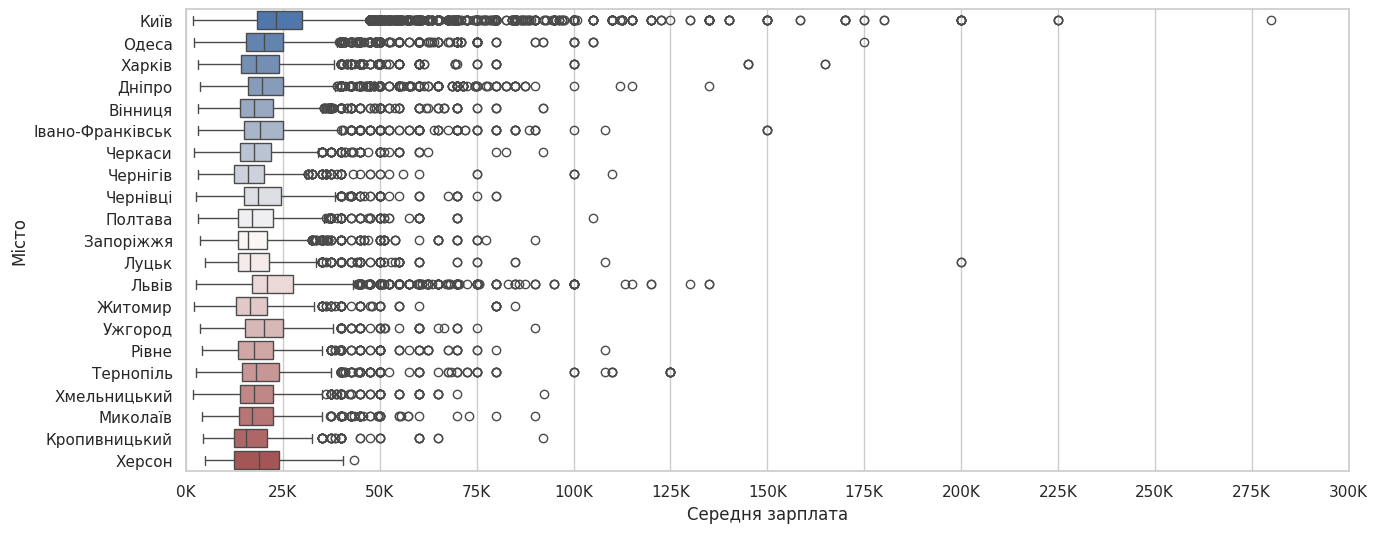

In [80]:
# побудуємо боксплоти середньої зарплати по містам України, при цьому обмежевши
# Київ з його двома дописами найбільших зарплат
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x="Середня зарплата", y="Місто", palette="vlag")

ax.xaxis.grid(True)
ax.set(xlim = (0, 300000))
xticks = np.arange(0, 300001, 25000)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{int(tick/1000)}K' for tick in xticks])

plt.show()

Спостерігаємо наступне, що медіана середньої зарплати (трішки дивно звучить та все ж) не перетинає жодне з міст в позначці зарплати 25000 грн., що не є позитивним знаком.

<ipython-input-81-f77166c5b2ff>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Середня зарплата", y="Категорія вакансії", palette="vlag")


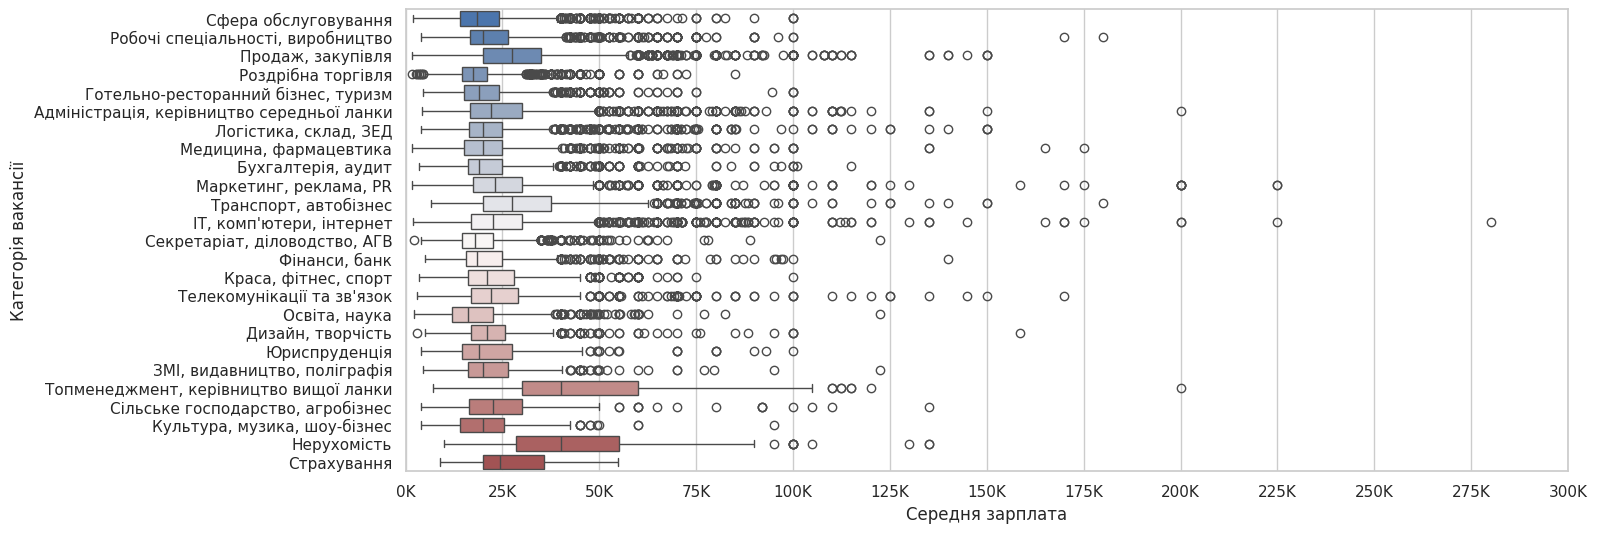

In [81]:
# і також для більшої наочності побудуємо боксплоти середньої зарплати по
# категоріям при цьому обмежевши категорії: адмiнiстрацiя,
# керівництво середньої ланки; Маркетинг, реклама, PR з максимальними зарплатами
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x="Середня зарплата", y="Категорія вакансії", palette="vlag")

ax.xaxis.grid(True)
ax.set(xlim = (0, 300000))
xticks = np.arange(0, 300001, 25000)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{int(tick/1000)}K' for tick in xticks])

plt.show()

З цього графіку видно, що найменша медіана середньої зарплати по категоріям є саме у "освітян та науковців", що нібито є очевидним та водночас сумним трендом на ринку праці України. В свою чергу в топі знаходяться категорії пов'язані з нерухомістю та топменеджментом, що в принципі теж доволі очевидно.

##Перевіримо статистичну значущість відмнінності між категоріями "ІТ" та "Освіта, наука"

Для мене доволі цікаво буде глянути чи статистично значущо відрізняються середні зарплати в категоряіх "Освіта, наука" та "ІТ" на ринку праці в Україні. Тож висуваємо гіпотезу H0 - що змін в зарплаті ніяких немає та H1 - що відмінність всеж є.

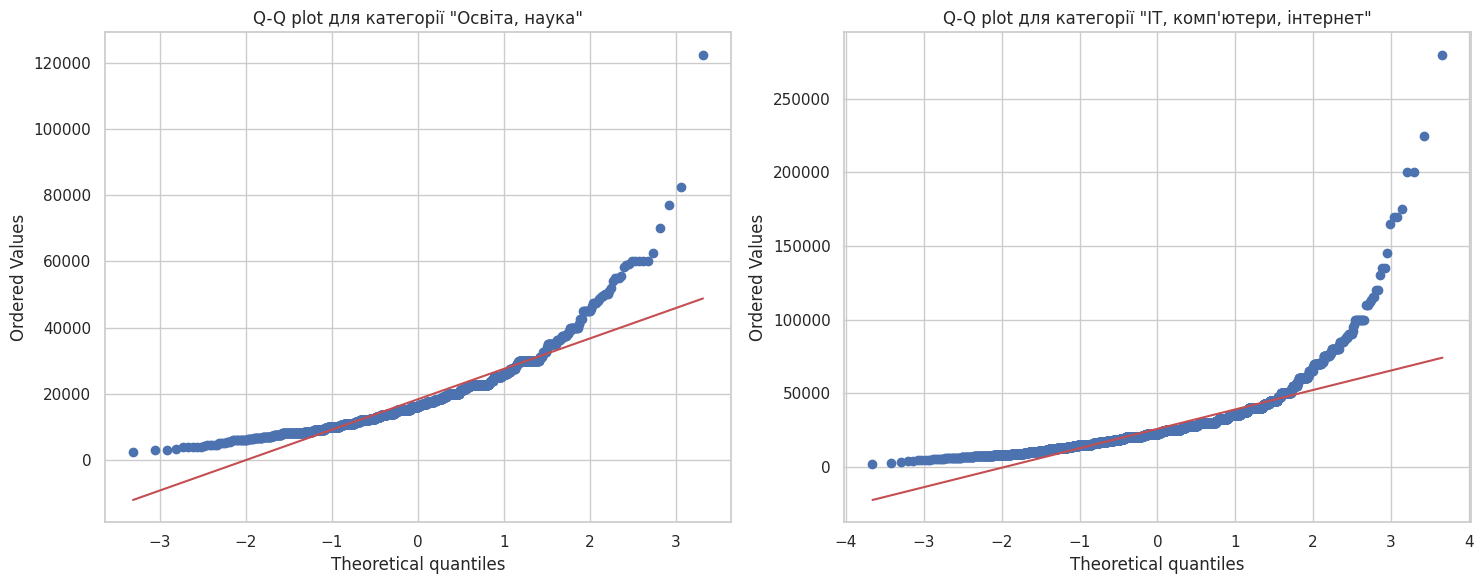

In [100]:
# спочатку перевіримо нормальність розподілу наших вибірок візуально через QQ-plot
import pylab
import scipy.stats as stats

f, ax = plt.subplots(1, 2, figsize=(15, 6))
group1 = df[df["Категорія вакансії"] == "Освіта, наука"]["Середня зарплата"]
stats.probplot(group1, dist="norm", plot=ax[0])
ax[0].set_title('Q-Q plot для категорії "Освіта, наука"')

group2 = df[df["Категорія вакансії"] == "IT, комп'ютери, інтернет"]["Середня зарплата"]
stats.probplot(group2, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q plot для категорії "IT, комп\'ютери, інтернет"')

plt.tight_layout()
plt.show()

Ситуація доволі показова, в обох випадках маємо розподіл, який відрізняється від нормального, тож в даному випадку будемо використовувати непараметричний аналог t-test, а саме критерій Манна-Уітні

In [105]:
# реалізуємо критерій Манна-Уітні
stat, p_value = mannwhitneyu(group1, group2)
print("Критерій Манна_уітні: p-value =", p_value)
if p_value > 0.01:
  print("Відхиляємо альтернативну гіпотезу (Н1) на користь Н0, тобто середні зарплати не відрізняються")
else:
  print("Відхиляємо нульову гіпотезу (Н0) на користь Н1, тобто середні зарплати відрізняються")

Критерій Манна_уітні: p-value = 4.2137629592020555e-117
Відхиляємо нульову гіпотезу (Н0) на користь Н1, тобто середні зарплати відрізняються


In [85]:
# зберігаємо датасет для подальшої візуалізації в power bi
df.to_csv("/content/drive/MyDrive/data for training/all_labour_market_ua_2024-05-23_edited1.csv")